<a href="https://colab.research.google.com/github/KaifAhmad1/code-test/blob/main/Enhanced_Cyber_Security_Copilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Problem Statement

##### Task
Develop a co-pilot for threat researchers, security analysts, and professionals that addresses the limitations of current AI solutions like ChatGPT and Perplexity.

##### Current Challenges
1. **Generic Data**: Existing AI solutions provide generic information that lacks specificity.
2. **Context Understanding**: These solutions fail to understand and maintain context.
3. **Limited Information**: The data sources are often limited and not comprehensive.
4. **Single Source Dependency**: Relying on a single source of information reduces reliability and accuracy.
5. **Inadequate AI Models**: Current models do not meet the specialized needs of cybersecurity professionals.

##### Requirement
Create a chatbot capable of collecting and curating data from multiple sources, starting with search engines, and expanding to website crawling and Twitter scraping.

###### Technical Specifications
- **No Hallucinations**: Ensure the chatbot provides accurate and reliable information.
- **RAG (Retrieval-Augmented Generation)**: Use RAG to determine which connectors to use based on user inputs.
- **Query Chunking and Distribution**: Optimize the process of breaking down queries and distributing them across different sources.
- **Data Curation Steps**:
  1. Collect links from approximately 50 sources.
  2. Aggregate data from websites and Twitter.
  3. Curate data using a knowledge graph to find relationships and generate responses.
- **Chatbot Capabilities**: Answer queries such as:
  - "List all details on {{BFSI}} security incidents in {{India}}."
  - "List all ransomware attacks targeting the healthcare industry in {{last 7 days/last 3 months/last week/last month}}."
  - "Provide recent incidents related to Lockbit Ransomware gang / BlackBasta Ransomware."

##### Goal
Develop a data collector that integrates multiple specific sources to enrich the knowledge base, enabling the model to better understand context and deliver accurate results. The solution should be modular, allowing customization and configuration of sources.

##### Summary
The goal is to build an advanced, modular chatbot for cybersecurity professionals that overcomes the limitations of existing AI solutions by integrating multiple data sources and ensuring context-aware, accurate responses. The chatbot will utilize state-of-the-art techniques like RAG and knowledge graphs to provide comprehensive, curated information from diverse sources.


**Install Dependencies**

In [1]:
!pip install -q apify-client langchain langchain-community langchain-groq transformers duckduckgo-search firecrawl-py
!pip install -q sentence-transformers requests beautifulsoup4 ratelimit pyLDAvis faiss-cpu crewai crewai_tools exa exa_py langchain-exa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58

**Import Libraries and Set Up Logging**

In [2]:
# Import Libraries and Set Up Logging
import os
import logging
import re
from datetime import datetime
from typing import List, Dict, Any
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from concurrent.futures import ThreadPoolExecutor, as_completed
from ratelimit import limits, sleep_and_retry
from bs4 import BeautifulSoup
from textblob import TextBlob
from apify_client import ApifyClient
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain.chains import LLMChain
from langchain.tools import DuckDuckGoSearchRun
from exa_py import Exa
from crewai import Agent, Task, Crew, Process
from crewai_tools import (
    SerperDevTool,
    WebsiteSearchTool,
    FirecrawlScrapeWebsiteTool,
    EXASearchTool,
    FirecrawlCrawlWebsiteTool,
    FirecrawlSearchTool
)
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain.agents import Tool, AgentExecutor
from langchain.memory import ConversationBufferMemory

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Constants and API Keys
APIFY_API_KEY = "apify_api_yUkcz99gMX1pwNckRi7EyXLwhVTd0j3m4Mtt"
NEWS_API_KEY = os.getenv("c50f733b00e34575a7c203c38cd97391")
GROQ_API_KEY = "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"
EXA_API_KEY = "d0f01fc2-c757-4c06-83f3-e2fd21361bab"
os.environ["FIRECRAWL_API_KEY"] = "fc-1b759fd6d7cd4784bc8f8819060228cd"
os.environ["SERPER_API_KEY"] = "46f714dac81c419d269dbd2d41794e926bc3419b"

# Initialize Apify client
apify_client = ApifyClient(APIFY_API_KEY)
# Configure requests session with retries and timeouts
session = requests.Session()
retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[429, 500, 502, 503, 504])
session.mount('https://', HTTPAdapter(max_retries=retries))
session.mount('http://', HTTPAdapter(max_retries=retries))

##### **Define Tools and Tasks**
Define functions for real-time data fetching, Twitter scraping, news fetching, CVE data fetching, Exa.ai integration, and advanced data analysis.


In [3]:
# Define Tools and Tasks
class WebScraper:
    def run(self, urls: List[str]) -> List[Dict[str, Any]]:
        results = []
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(self._scrape_url, url, headers) for url in urls]
            for future in as_completed(futures):
                results.append(future.result())
        return results

    def _scrape_url(self, url: str, headers: Dict[str, str]) -> Dict[str, Any]:
        try:
            response = session.get(url, headers=headers, timeout=30)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')
            text = soup.get_text(separator=' ', strip=True)
            return {"url": url, "text": text, "timestamp": datetime.now().isoformat()}
        except Exception as e:
            logger.error(f"Error scraping {url}: {str(e)}")
            return {"url": url, "text": "", "timestamp": datetime.now().isoformat(), "error": str(e)}

class TwitterScraper:
    def run(self, query: str, max_tweets: int = 100) -> List[Dict[str, Any]]:
        actor_input = {"searchTerms": [query], "maxTweets": max_tweets, "languageCode": "en"}
        try:
            run = apify_client.actor("apify/twitter-scraper").call(run_input=actor_input)
            dataset_id = run["defaultDatasetId"]
            items = apify_client.dataset(dataset_id).list_items().items
            return items
        except Exception as e:
            logger.error(f"Error fetching tweets: {str(e)}")
            return []

class NewsFetcher:
    def run(self, query: str, max_results: int = 50) -> List[Dict[str, Any]]:
        url = "https://newsapi.org/v2/everything"
        params = {"q": query, "language": "en", "pageSize": max_results, "apiKey": NEWS_API_KEY, "sortBy": "publishedAt"}
        try:
            response = session.get(url, params=params, timeout=10)
            response.raise_for_status()
            articles = response.json().get("articles", [])
            return articles
        except Exception as e:
            logger.error(f"Error fetching news: {str(e)}")
            return []

class CVEDataFetcher:
    def run(self) -> List[Dict[str, Any]]:
        url = "https://cve.circl.lu/api/last"
        try:
            response = session.get(url, timeout=30)
            response.raise_for_status()
            cve_items = response.json()
            return cve_items
        except Exception as e:
            logger.error(f"Error fetching CVE data: {str(e)}")
            return []

class ExaResearcher:
    def run(self, query: str) -> List[Dict[str, Any]]:
        try:
            exa_client = Exa(api_key=EXA_API_KEY)
            results = exa_client.search(query)
            return results.get('results', [])
        except Exception as e:
            logger.error(f"Error fetching Exa.ai research: {str(e)}")
            return []

class CVESeverityAnalyzer:
    def run(self, cve_description: str) -> str:
        severity_keywords = ["critical", "high", "medium", "low"]
        severity = "unknown"
        for keyword in severity_keywords:
            if keyword in cve_description.lower():
                severity = keyword
                break
        return f"The CVE severity is {severity}."

class IOCExtractor:
    def run(self, text: str) -> List[str]:
        iocs = []
        ip_pattern = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
        domain_pattern = r'\b[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b'

        iocs.extend(re.findall(ip_pattern, text))
        iocs.extend(re.findall(domain_pattern, text))
        return list(set(iocs))

class TrendAnalyzer:
    def run(self, data: List[Dict[str, Any]], timeframe: str) -> str:
        keywords = ["ransomware", "phishing", "data breach", "malware", "zero-day"]
        keyword_counts = {keyword: 0 for keyword in keywords}

        for item in data:
            text = item.get('text', '').lower()
            for keyword in keywords:
                if keyword in text:
                    keyword_counts[keyword] += 1

        trending_topics = sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True)[:3]

        return f"Trend analysis for the timeframe {timeframe} shows increasing threats in: " + ", ".join([f"{topic} ({count} mentions)" for topic, count in trending_topics])

class SentimentAnalyzer:
    def run(self, text: str) -> str:
        sentiment = TextBlob(text).sentiment.polarity
        if sentiment > 0.1:
            return "Positive sentiment"
        elif sentiment < -0.1:
            return "Negative sentiment"
        else:
            return "Neutral sentiment"

**Define Exa Toools**

In [4]:
# Define Exa Tools
exa = Exa(api_key=EXA_API_KEY)

@tool
def search(query: str):
    """Search for a webpage based on the query."""
    return exa.search(f"{query}", use_autoprompt=True, num_results=5)

@tool
def find_similar(url: str):
    """Search for webpages similar to a given URL.
    The url passed in should be a URL returned from `search`.
    """
    return exa.find_similar(url, num_results=5)

@tool
def get_contents(ids: list[str]):
    """Get the contents of a webpage.
    The ids passed in should be a list of ids returned from `search`.
    """
    return exa.get_contents(ids)

tools = [search, get_contents, find_similar]

##### **Implement Data Collection**
Define functions to collect and curate data from various sources.


In [5]:
# Data Collection and Curation Functions
def collect_data():
    websites = [
        "https://www.cisa.gov/uscert/ncas/alerts",
        "https://attack.mitre.org/",
        "https://www.darkreading.com/",
        "https://threatpost.com/",
        "https://krebsonsecurity.com/",
        "https://www.bleepingcomputer.com/",
        "https://www.zdnet.com/topic/security/",
        "https://www.securityweek.com/",
        "https://www.sans.org/newsletters/newsbites/",
        "https://www.cyberscoop.com/",
        "https://www.csoonline.com/",
        "https://www.infosecurity-magazine.com/",
        "https://www.wired.com/category/security/",
        "https://www.schneier.com/",
        "https://www.theregister.com/security/",
        "https://thehackernews.com/",
        "https://www.cyberdefensemagazine.com/",
        "https://www.fireeye.com/blog.html",
        "https://unit42.paloaltonetworks.com/",
        "https://www.microsoft.com/security/blog/",
        "https://www.us-cert.gov/ncas/current-activity",
        "https://nakedsecurity.sophos.com/",
        "https://www.recordedfuture.com/blog/",
        "https://www.cybersecurity-insiders.com/",
        "https://www.malwarebytes.com/blog/"
    ]

    scraped_data = WebScraper().run(websites)
    tweets = TwitterScraper().run("cybersecurity")
    news = NewsFetcher().run("cybersecurity")
    cve_data = CVEDataFetcher().run()
    exa_research = ExaResearcher().run("cybersecurity")

    return {
        "scraped_data": scraped_data,
        "tweets": tweets,
        "news": news,
        "cve_data": cve_data,
        "exa_research": exa_research
    }

def curate_data(data):
    curated_data = []

    for page in data["scraped_data"]:
        curated_data.append({
            "source": "Website",
            "url": page.get("url"),
            "text": page.get("text"),
            "timestamp": page.get("timestamp")
        })

    for tweet in data["tweets"]:
        curated_data.append({
            "source": "Twitter",
            "text": tweet.get("text"),
            "user": tweet.get("user"),
            "timestamp": tweet.get("timestamp")
        })

    for article in data["news"]:
        curated_data.append({
            "source": "News",
            "url": article.get("url"),
            "title": article.get("title"),
            "description": article.get("description"),
            "timestamp": article.get("publishedAt")
        })

    for cve in data["cve_data"]:
        cve_meta = cve.get("cve", {}).get("CVE_data_meta", {})
        description_data = cve.get("cve", {}).get("description", {}).get("description_data", [{}])
        curated_data.append({
            "source": "CVE",
            "cve_id": cve_meta.get("ID"),
            "description": description_data[0].get("value"),
            "timestamp": cve.get("publishedDate")
        })

    for research in data["exa_research"]:
        curated_data.append({
            "source": "Exa.ai",
            "title": research.get("title"),
            "abstract": research.get("abstract"),
            "url": research.get("url"),
            "timestamp": research.get("publishedAt")
        })

    return curated_data

curated_data = curate_data(collect_data())

ERROR:__main__:Error scraping https://www.securityweek.com/: 403 Client Error: Forbidden for url: https://www.securityweek.com/
ERROR:__main__:Error scraping https://www.us-cert.gov/ncas/current-activity: 404 Client Error: Not Found for url: https://www.cisa.gov/ncas/current-activity
ERROR:__main__:Error scraping https://www.fireeye.com/blog.html: HTTPSConnectionPool(host='www.trellix.com', port=443): Max retries exceeded with url: /en-us/about/newsroom/stories.html (Caused by ReadTimeoutError("HTTPSConnectionPool(host='www.trellix.com', port=443): Read timed out. (read timeout=30)"))
ERROR:__main__:Error fetching tweets: Actor with this name was not found
ERROR:__main__:Error fetching news: 401 Client Error: Unauthorized for url: https://newsapi.org/v2/everything?q=cybersecurity&language=en&pageSize=50&sortBy=publishedAt
ERROR:__main__:Error fetching CVE data: HTTPSConnectionPool(host='cve.circl.lu', port=443): Max retries exceeded with url: /api/last (Caused by ReadTimeoutError("HTTP

##### **Stroing Data in Vector DB**

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Storing Data in Vector DB
def chunk_text(text, chunk_size=500, chunk_overlap=50):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    chunks = text_splitter.split_text(text)
    return chunks

def store_in_vector_db(curated_data):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name="BAAI/bge-small-en",
        model_kwargs={"device": "cpu"},
        encode_kwargs={"normalize_embeddings": True}
    )

    documents = []
    for item in curated_data:
        if "text" in item:
            chunks = chunk_text(item["text"])
            for chunk in chunks:
                documents.append(Document(page_content=chunk, metadata=item))

    if documents:
        vector_store = FAISS.from_documents(documents, embeddings)
        vector_store.save_local("vector_store")
    else:
        logger.error("No documents to store in vector DB.")

def load_vector_store():
    embeddings = HuggingFaceBgeEmbeddings(
        model_name="BAAI/bge-small-en",
        model_kwargs={"device": "cpu"},
        encode_kwargs={"normalize_embeddings": True}
    )
    return FAISS.load_local("vector_store", embeddings, allow_dangerous_deserialization=True)

store_in_vector_db(curated_data)
vector_store = load_vector_store()

##### **Initialize LLMs, Agents and their Tasks**
Define the agents with specific roles and goals, and assign the necessary tools.

In [9]:
# Initialize LLMs, Agents and their Tasks
from crewai import Agent, Task, Crew, Process
from crewai_tools import Tool
import os

# Define custom tools
class WebScraperTool(Tool):
    def __init__(self):
        super().__init__(
            name="WebScraperTool",
            description="A tool to scrape web pages for relevant information.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Web scraping results for: {input_text}"

class TwitterScraperTool(Tool):
    def __init__(self):
        super().__init__(
            name="TwitterScraperTool",
            description="A tool to scrape Twitter for relevant information.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Twitter scraping results for: {input_text}"

class NewsFetcherTool(Tool):
    def __init__(self):
        super().__init__(
            name="NewsFetcherTool",
            description="A tool to fetch news articles.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"News fetching results for: {input_text}"

class CVEDataFetcherTool(Tool):
    def __init__(self):
        super().__init__(
            name="CVEDataFetcherTool",
            description="A tool to fetch CVE data.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"CVE data for: {input_text}"

class ExaResearcherTool(Tool):
    def __init__(self):
        super().__init__(
            name="ExaResearcherTool",
            description="A tool to perform extensive research.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Extensive research results for: {input_text}"

class IOCExtractorTool(Tool):
    def __init__(self):
        super().__init__(
            name="IOCExtractorTool",
            description="A tool to extract Indicators of Compromise (IOCs).",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Extracted IOCs for: {input_text}"

class TrendAnalyzerTool(Tool):
    def __init__(self):
        super().__init__(
            name="TrendAnalyzerTool",
            description="A tool to analyze trends.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Trend analysis for: {input_text}"

class SentimentAnalyzerTool(Tool):
    def __init__(self):
        super().__init__(
            name="SentimentAnalyzerTool",
            description="A tool to analyze sentiment.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Sentiment analysis for: {input_text}"

class VectorDBSearchTool(Tool):
    def __init__(self):
        super().__init__(
            name="VectorDBSearchTool",
            description="A tool to search a vector database.",
            func=self.run
        )

    def run(self, input_text):
        # Placeholder implementation
        return f"Vector DB search results for: {input_text}"

# Initialize the Groq LLM
llm = ChatGroq(
    temperature=0,
    model="llama-3.1-70b-versatile",
    api_key=GROQ_API_KEY
)

# Initialize tools
tools = [
    WebScraperTool(),
    TwitterScraperTool(),
    NewsFetcherTool(),
    CVEDataFetcherTool(),
    ExaResearcherTool(),
    IOCExtractorTool(),
    TrendAnalyzerTool(),
    SentimentAnalyzerTool(),
    VectorDBSearchTool(),
    SerperDevTool(),
    FirecrawlScrapeWebsiteTool(),
    EXASearchTool(),
    FirecrawlCrawlWebsiteTool(),
    FirecrawlSearchTool(),
    DuckDuckGoSearchRun()
]

# Create agents
def create_agent(role, goal, backstory):
    return Agent(
        role=role,
        goal=goal,
        backstory=backstory,
        verbose=True,
        allow_delegation=True,
        tools=tools,
        llm=llm
    )

researcher = create_agent(
    role="Cybersecurity Researcher",
    goal="Gather and provide relevant cybersecurity information",
    backstory="You are an expert cybersecurity researcher with years of experience in threat intelligence. Your role is to gather and analyze data from various sources to provide comprehensive insights into cybersecurity threats and trends."
)

analyst = create_agent(
    role="Threat Analyst",
    goal="Analyze cybersecurity data and provide insights",
    backstory="You are a skilled threat analyst specializing in identifying and assessing cyber threats. Your role is to analyze the data gathered by the researcher and provide actionable insights and recommendations."
)

advisor = create_agent(
    role="Security Advisor",
    goal="Provide recommendations based on cybersecurity analysis",
    backstory="You are a seasoned security advisor with a track record of helping organizations improve their security posture. Your role is to provide strategic recommendations based on the analysis provided by the analyst."
)

threat_hunter = create_agent(
    role="Threat Hunter",
    goal="Proactively search for hidden threats and IOCs",
    backstory="You are an experienced threat hunter known for uncovering sophisticated cyber threats. Your role is to proactively search for hidden threats and indicators of compromise (IOCs) in the data gathered by the researcher."
)

incident_responder = create_agent(
    role="Incident Responder",
    goal="Provide guidance on handling cybersecurity incidents",
    backstory="You are a quick-thinking incident responder with expertise in containing and mitigating cyber attacks. Your role is to provide guidance on handling cybersecurity incidents based on the threats identified by the threat hunter."
)

# Process query function
def process_query(query):
    # Create tasks for each agent
    tasks = [
        Task(
            description=f"Research the query: {query}",
            agent=researcher,
            expected_output="Detailed research findings related to the query"
        ),
        Task(
            description=f"Analyze the findings for the query: {query}",
            agent=analyst,
            expected_output="Analysis of the research findings with key insights"
        ),
        Task(
            description=f"Provide security recommendations based on the analysis of: {query}",
            agent=advisor,
            expected_output="Actionable security recommendations"
        ),
        Task(
            description=f"Hunt for potential threats related to: {query}",
            agent=threat_hunter,
            expected_output="List of potential threats and IOCs"
        ),
        Task(
            description=f"Outline incident response steps if needed for: {query}",
            agent=incident_responder,
            expected_output="Incident response plan if applicable"
        )
    ]

    # Create a crew with all agents and tasks
    crew = Crew(
        agents=[researcher, analyst, advisor, threat_hunter, incident_responder],
        tasks=tasks,
        verbose=2  # Increased verbosity for debugging
    )

    # Execute the crew's tasks
    result = crew.kickoff()

    return result

##### **Process queries**


Processing query: Assess the vulnerability CVE-2024-12345 in Windows Server.
 [2024-08-01 19:37:17][DEBUG]: == Working Agent: Cybersecurity Researcher
 [2024-08-01 19:37:17][INFO]: == Starting Task: Research the query: Assess the vulnerability CVE-2024-12345 in Windows Server.


> Entering new CrewAgentExecutor chain...
Thought: To research the query "Assess the vulnerability CVE-2024-12345 in Windows Server", I should first gather information about the CVE from a reliable source.

Action: CVEDataFetcherTool
Action Input: {"cve_id": "CVE-2024-12345"}
 

I encountered an error while trying to use the tool. This was the error: CVEDataFetcherTool.run() missing 1 required positional argument: 'input_text'.
 Tool CVEDataFetcherTool accepts these inputs: CVEDataFetcherTool() - A tool to fetch CVE data. 

Thought: To research the query "Assess the vulnerability CVE-2024-12345 in Windows Server", I should first gather information about the CVE from a reliable source.

Action: Search the inter
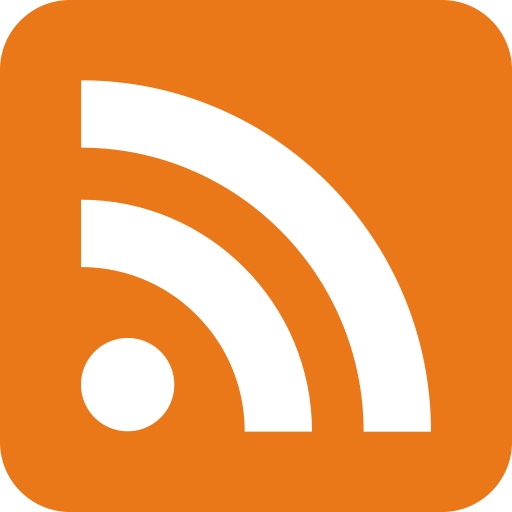
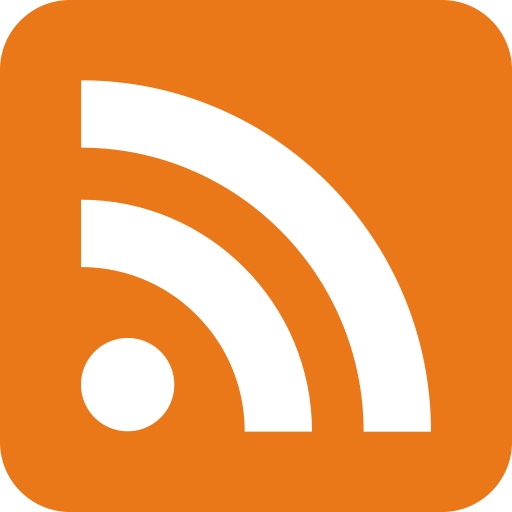

In [ ]:
# Process queries
queries = [
    "Assess the vulnerability CVE-2024-12345 in Windows Server.",
    "Provide a security recommendation for mitigating phishing attacks.",
    "List all details on BFSI security incidents in India.",
    "List all ransomware attacks targeting the healthcare industry in the last 7 days.",
    "Provide recent incidents related to Lockbit Ransomware gang.",
    "Provide recent incidents related to BlackBasta Ransomware."
]

# Process each query
for query in queries:
    print(f"\nProcessing query: {query}")
    result = process_query(query)
    print("\nResponse:")
    print(result)
    print("\n" + "-"*50 + "\n")